# Quanthub: Review Ratings Challenge

The goal of this case is to wrangle, explore, and model online review ratings from visitors to various locations. The data consists of user ratings ranging from 1 (poor) to 5 (great) and has been aggregated into average ratings per user per location category.

**Task:** Import review_ratings_headers.txt file

In [1]:
import re
from functools import partial
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
import pydotplus
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

# plotting defaults
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (18, 12)
get_colors = lambda length: plt.get_cmap('Spectral')(np.linspace(0, 1.0, length))

In [2]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (18, 12)

In [3]:
review_ratings_headers_raw = [str(header) for header in open('./data/review_ratings_headers.txt', 'r').readlines()] 
review_ratings_headers_raw

['Attribute 1 : Unique user id \n',
 'Attribute 2 : Average ratings on churches \n',
 'Attribute 3 : Average ratings on resorts \n',
 'Attribute 4 : Average ratings on beaches \n',
 'Attribute 5 : Average ratings on parks \n',
 'Attribute 6 : Average ratings on theatres \n',
 'Attribute 7 : Average ratings on museums \n',
 'Attribute 8 : Average ratings on malls \n',
 'Attribute 9 : Average ratings on zoo \n',
 'Attribute 10 : Average ratings on restaurants \n',
 'Attribute 11 : Average ratings on pubs/bars \n',
 'Attribute 12 : Average ratings on local services \n',
 'Attribute 13 : Average ratings on burger/pizza shops \n',
 'Attribute 14 : Average ratings on hotels/other lodgings \n',
 'Attribute 15 : Average ratings on juice bars \n',
 'Attribute 16 : Average ratings on art galleries \n',
 'Attribute 17 : Average ratings on dance clubs \n',
 'Attribute 18 : Average ratings on swimming pools \n',
 'Attribute 19 : Average ratings on gyms \n',
 'Attribute 20 : Average ratings on baker

**Task:**
1. Extract "user" and "id" from the first line and combine with an underscore.
1. In each line after the first line, extract the word(s) after "on" in each line, removing special characters (e.g. /n, &, etc.). 
1. If there is more than one word, combine the words with a single underscore. 
1. Put the words into a list to use as headers for your dataset later.

In [4]:
review_ratings_headers = []
for header in review_ratings_headers_raw:
    header_cleaned = ''.join([char if char.isalnum() else ' ' for char in header]).strip()
    on_pos = header_cleaned.find('on')
    if on_pos != -1:
        review_ratings_headers.append(
            '_'.join([word.strip() for word in header_cleaned[on_pos+len('on'):].split()])
        )
    else:
        review_ratings_headers.append(
            '_'.join(header_cleaned[header_cleaned.find('user'):].split(' '))
        )

In [5]:
review_ratings_headers

['user_id',
 'churches',
 'resorts',
 'beaches',
 'parks',
 'theatres',
 'museums',
 'malls',
 'zoo',
 'restaurants',
 'pubs_bars',
 'local_services',
 'burger_pizza_shops',
 'hotels_other_lodgings',
 'juice_bars',
 'art_galleries',
 'dance_clubs',
 'swimming_pools',
 'gyms',
 'bakeries',
 'beauty_spas',
 'cafes',
 'view_points',
 'monuments',
 'gardens']

Question 1: How many headers are there with 2 or more words combined by an underscore?

In [6]:
np.sum([1 if len(header.split('_')) > 1 else 0 for header in review_ratings_headers])

11

Question 2: How many underscores are there in all of the headers?

In [7]:
np.sum([len(header.split('_')) - 1 if len(header.split('_')) > 1 else 0 for header in review_ratings_headers])

13

**Task:** Read in review_ratings.csv, set names as the cleaned headers list from above, skip the first row, and do not include an index column

In [8]:
review_ratings = pd.read_csv(
    './data/review_ratings.csv', 
    header=0, 
    names=review_ratings_headers, 
    index_col=False
)
review_ratings.head()

,user_id,churches,resorts,beaches,parks,theatres,museums,malls,zoo,restaurants,...,art_galleries,dance_clubs,swimming_pools,gyms,bakeries,beauty_spas,cafes,view_points,monuments,gardens
0,User 777,1.90,1.93,1.95,5.00,2.02,2.00,2.01,2.00,2.01,...,1.99,1.62,1.41,1.40,1.41,1.44,0.58,0.99,1.89,1.89
1,User 5278,1.37,1.59,1.42,1.81,1.80,1.79,1.81,2.65,2.63,...,5.00,5.00,0.52,0.50,0.51,0.63,1.43,1.51,1.36,1.35
2,User 2374,0.75,0.79,2.03,2.88,5.00,5.00,1.64,1.59,1.56,...,0.78,0.77,0.78,0.79,1.10,0.73,0.70,0.70,0.70,0.73
3,User 943,1.22,5.00,1.28,5.00,5.00,2.83,2.58,1.72,5.00,...,0.96,1.16,0.58,0.58,0.59,0.71,1.27,5.00,1.26,1.21
4,User 4082,1.12,1.15,5.00,3.27,5.00,5.00,5.00,1.99,1.79,...,1.76,1.78,0.51,0.00,0.00,0.00,0.50,1.09,1.08,1.09


Question 3: How many rows are in the ratings dataset?

In [9]:
review_ratings.shape[0]

4456

**Task:** Import review_ratings_with_headers.csv

In [10]:
review_ratings_with_headers = pd.read_csv('./data/review_ratings_with_headers.csv')
review_ratings_with_headers.head()

,user_id,churches,resorts,beaches,parks,theatres,museums,malls,zoo,restaurants,...,art_galleries,dance_clubs,swimming_pools,gyms,bakeries,beauty_spas,cafes,view_points,monuments,gardens
0,User 777,1.90,1.93,1.95,5.00,2.02,2.00,2.01,2.00,2.01,...,1.99,1.62,1.41,1.40,1.41,1.44,0.58,0.99,1.89,1.89
1,User 5278,1.37,1.59,1.42,1.81,1.80,1.79,1.81,2.65,2.63,...,5.00,5.00,0.52,0.50,0.51,0.63,1.43,1.51,1.36,1.35
2,User 2374,0.75,0.79,2.03,2.88,5.00,5.00,1.64,1.59,1.56,...,0.78,0.77,0.78,0.79,1.10,0.73,0.70,0.70,0.70,0.73
3,User 943,1.22,5.00,1.28,5.00,5.00,2.83,2.58,1.72,5.00,...,0.96,1.16,0.58,0.58,0.59,0.71,1.27,5.00,1.26,1.21
4,User 4082,1.12,1.15,5.00,3.27,5.00,5.00,5.00,1.99,1.79,...,1.76,1.78,0.51,0.00,0.00,0.00,0.50,1.09,1.08,1.09


**Task:** Explore data types in the dataset

In [11]:
review_ratings_with_headers.dtypes

user_id                   object
churches                 float64
resorts                  float64
beaches                  float64
parks                    float64
theatres                 float64
museums                  float64
malls                    float64
zoo                      float64
restaurants              float64
pubs_bars                float64
local_services            object
burger_pizza_shops       float64
hotels_other_lodgings    float64
juice_bars               float64
art_galleries            float64
dance_clubs              float64
swimming_pools           float64
gyms                     float64
bakeries                 float64
beauty_spas              float64
cafes                    float64
view_points              float64
monuments                float64
gardens                  float64
dtype: object

In [12]:
review_ratings_with_headers['user_id'].describe()

count          4456
unique         4456
top       User 4289
freq              1
Name: user_id, dtype: object

Question 4: What data type is user_id?

It is an object data type

**Task:** Find special characters that are in one of the columns, replace with 0, and convert to continuous/float type

Looks like the only feature column that is not a float data type is the `local_services` column, so we'll explore that.

In [13]:
local_services = review_ratings_with_headers['local_services']
review_ratings_with_headers['local_services'] = \
    review_ratings_with_headers['local_services'].apply(
        lambda entry: float(''.join(
            [char if char.isdigit() or char == '.' \
                 else '0' for char in entry])
        )
    )

In [14]:
review_ratings.dtypes

user_id                   object
churches                 float64
resorts                  float64
beaches                  float64
parks                    float64
theatres                 float64
museums                  float64
malls                    float64
zoo                      float64
restaurants              float64
pubs_bars                float64
local_services            object
burger_pizza_shops       float64
hotels_other_lodgings    float64
juice_bars               float64
art_galleries            float64
dance_clubs              float64
swimming_pools           float64
gyms                     float64
bakeries                 float64
beauty_spas              float64
cafes                    float64
view_points              float64
monuments                float64
gardens                  float64
dtype: object

Question 5: What was the string that contained the special characters?

In [15]:
for entry in local_services:
    for char in entry:
        if char.isdigit() or char == '.':
            pass
        else:
            print(entry)
            break

2	2.


Question 6: What is the mean of the variable now that it has been converted to type continuous/float?

In [16]:
review_ratings_with_headers['local_services'].describe()

count    4456.000000
mean        2.590346
std         3.289532
min         0.780000
25%         1.580000
50%         2.000000
75%         3.172500
max       202.000000
Name: local_services, dtype: float64

**Task:** Fill missing values with 0 and run summary statistics on the dataset

In [17]:
review_ratings_with_headers = \
    review_ratings_with_headers.fillna(value=0)
review_ratings_with_headers.describe()

,churches,resorts,beaches,parks,theatres,museums,malls,zoo,restaurants,pubs_bars,...,art_galleries,dance_clubs,swimming_pools,gyms,bakeries,beauty_spas,cafes,view_points,monuments,gardens
count,4456.000000,4456.000000,4456.000000,4456.000000,4456.000000,4456.000000,4456.000000,4456.000000,4456.000000,4456.000000,...,4456.000000,4456.000000,4456.000000,4456.000000,4456.000000,4456.000000,4456.000000,4456.000000,4456.000000,4456.000000
mean,1.452987,2.304504,2.483409,2.790247,2.966690,2.908746,3.378438,2.542897,3.125222,2.832208,...,2.224661,1.189217,0.950121,0.828218,0.966405,0.994675,0.962089,1.734473,1.523761,1.549632
std,0.829420,1.418781,1.246003,1.304826,1.339469,1.288723,1.414961,1.116005,1.357130,1.306910,...,1.727771,1.109464,0.984810,0.963599,1.198750,1.183759,0.919017,1.585888,1.313043,1.165424
min,0.000000,0.000000,0.000000,0.830000,1.120000,1.110000,1.120000,0.860000,0.840000,0.810000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.920000,1.360000,1.530000,1.737500,1.780000,1.790000,1.940000,1.620000,1.800000,1.630000,...,0.860000,0.690000,0.580000,0.530000,0.520000,0.540000,0.570000,0.740000,0.790000,0.880000
50%,1.340000,1.880000,2.065000,2.450000,2.670000,2.700000,3.230000,2.170000,2.800000,2.680000,...,1.330000,0.800000,0.740000,0.690000,0.690000,0.690000,0.770000,1.020000,1.070000,1.290000
75%,1.810000,2.670000,2.740000,4.062500,4.330000,3.910000,5.000000,3.192500,5.000000,3.492500,...,4.900000,1.150000,0.910000,0.840000,0.860000,0.860000,1.000000,2.060000,1.540000,1.650000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


Question 7: What is the IQR of ratings for malls?

In [18]:
review_ratings_with_headers['malls'].quantile(0.75) \
    - review_ratings_with_headers['malls'].quantile(0.25)

3.06

**Task:** Import review_ratings_processed.csv

In [19]:
review_ratings_processed = \
    pd.read_csv('./data/review_ratings_processed.csv')
review_ratings_processed.head()

,user_id,churches,resorts,beaches,parks,theatres,museums,malls,zoo,restaurants,...,art_galleries,dance_clubs,swimming_pools,gyms,bakeries,beauty_spas,cafes,view_points,monuments,gardens
0,User 777,1.90,1.93,1.95,5.00,2.02,2.00,2.01,2.00,2.01,...,1.99,1.62,1.41,1.40,1.41,1.44,0.58,0.99,1.89,1.89
1,User 5278,1.37,1.59,1.42,1.81,1.80,1.79,1.81,2.65,2.63,...,5.00,5.00,0.52,0.50,0.51,0.63,1.43,1.51,1.36,1.35
2,User 2374,0.75,0.79,2.03,2.88,5.00,5.00,1.64,1.59,1.56,...,0.78,0.77,0.78,0.79,1.10,0.73,0.70,0.70,0.70,0.73
3,User 943,1.22,5.00,1.28,5.00,5.00,2.83,2.58,1.72,5.00,...,0.96,1.16,0.58,0.58,0.59,0.71,1.27,5.00,1.26,1.21
4,User 4082,1.12,1.15,5.00,3.27,5.00,5.00,5.00,1.99,1.79,...,1.76,1.78,0.51,0.00,0.00,0.00,0.50,1.09,1.08,1.09


**Task:** Find the variables that are most correlated with each other

In [20]:
review_ratings_processed_corr_mat = review_ratings_processed.iloc[:, 1:].corr()
review_ratings_processed_corr_mat

,churches,resorts,beaches,parks,theatres,museums,malls,zoo,restaurants,pubs_bars,...,art_galleries,dance_clubs,swimming_pools,gyms,bakeries,beauty_spas,cafes,view_points,monuments,gardens
churches,1.000000,0.260257,0.156641,0.073435,0.039801,-0.092727,-0.265487,-0.185384,-0.294143,-0.275124,...,-0.137725,0.067658,0.130032,0.161656,0.179255,0.204207,0.309205,0.372235,0.411541,0.486649
resorts,0.260257,1.000000,0.317444,0.166368,0.152136,0.049450,-0.059706,0.006087,-0.062348,-0.097929,...,-0.065658,-0.041750,-0.070500,-0.019084,0.031711,0.092644,0.095150,0.026616,0.093188,0.135329
beaches,0.156641,0.317444,1.000000,0.399979,0.323741,0.153930,-0.074089,-0.180444,-0.223845,-0.175301,...,-0.137319,-0.027532,-0.085583,-0.116461,-0.082800,-0.013352,0.007740,0.148735,0.123528,0.085184
parks,0.073435,0.166368,0.399979,1.000000,0.623595,0.307184,-0.075504,-0.127226,-0.170477,-0.118112,...,-0.276030,0.010401,-0.132519,-0.181254,-0.197990,-0.094858,-0.056405,0.288137,0.175580,0.090223
theatres,0.039801,0.152136,0.323741,0.623595,1.000000,0.481160,0.081622,0.002951,-0.168624,-0.098473,...,-0.330776,-0.067829,-0.192170,-0.241485,-0.259324,-0.197368,-0.135495,0.126214,0.132492,0.099770
museums,-0.092727,0.049450,0.153930,0.307184,0.481160,1.000000,0.390207,0.203442,0.116491,-0.021917,...,-0.185366,-0.156462,-0.233413,-0.269439,-0.267716,-0.228659,-0.191088,-0.082948,-0.083190,-0.063072
malls,-0.265487,-0.059706,-0.074089,-0.075504,0.081622,0.390207,1.000000,0.394529,0.426686,0.250479,...,0.100706,-0.145954,-0.208489,-0.223856,-0.280185,-0.234097,-0.255272,-0.353092,-0.217277,-0.243462
zoo,-0.185384,0.006087,-0.180444,-0.127226,0.002951,0.203442,0.394529,1.000000,0.527385,0.554738,...,-0.061247,-0.120274,-0.205291,-0.236918,-0.277632,-0.249765,-0.274409,-0.250012,-0.160518,-0.133380
restaurants,-0.294143,-0.062348,-0.223845,-0.170477,-0.168624,0.116491,0.426686,0.527385,1.000000,0.564639,...,0.144566,-0.111435,-0.230312,-0.268960,-0.279472,-0.165755,-0.183172,-0.267634,-0.256989,-0.321528
pubs_bars,-0.275124,-0.097929,-0.175301,-0.118112,-0.098473,-0.021917,0.250479,0.554738,0.564639,1.000000,...,0.043559,-0.028163,-0.213184,-0.274719,-0.320691,-0.246146,-0.230700,-0.178047,-0.200229,-0.260093


In [21]:
# Retrieves correlations of distinct
# feature pairs, removed correlations of
# features with themselves because they will
# be 1
corr_sorted_pairs = \
    review_ratings_processed_corr_mat \
        .unstack() \
        .sort_values(ascending=False)

corr_sorted_pairs = \
    corr_sorted_pairs[corr_sorted_pairs != 1][::2]

print('Most Positively-correlated pairs: \n{}\n'.format(corr_sorted_pairs[:10]))
print('Most Negatively-correlated pairs: \n{}\n'.format(corr_sorted_pairs[-10:][::-1]))

Most Positively-correlated pairs: 
parks               theatres                 0.623595
pubs_bars           restaurants              0.564639
zoo                 pubs_bars                0.554738
restaurants         zoo                      0.527385
gyms                swimming_pools           0.524064
juice_bars          hotels_other_lodgings    0.511304
churches            gardens                  0.486649
museums             theatres                 0.481160
view_points         monuments                0.471765
burger_pizza_shops  hotels_other_lodgings    0.470846
dtype: float64

Most Negatively-correlated pairs: 
view_points     malls                -0.353092
local_services  cafes                -0.332300
art_galleries   theatres             -0.330776
view_points     burger_pizza_shops   -0.322592
gardens         restaurants          -0.321528
bakeries        pubs_bars            -0.320691
parks           juice_bars           -0.315786
monuments       juice_bars           -0.29703

Question 8: What variables is the most negatively correlated with **restaurants**?

In [22]:
review_ratings_processed_corr_mat['restaurants'][review_ratings_processed_corr_mat['restaurants'] < 0].idxmin()

'gardens'

**Task:** Group each variable into 10 equal-width bins and calculate the **mean malls** rating for each bin

In [23]:
review_ratings_processed_bins = \
    review_ratings_processed.iloc[:,1:].apply(
        partial(
            lambda col, bins: pd.cut(col, bins=bins, retbins=True)
            , bins=10
        )
        , 
        axis=0
    )
review_ratings_processed_bins

churches                 ([(1.5, 2.0], (1.0, 1.5], (0.5, 1.0], (1.0, 1....
resorts                  ([(1.5, 2.0], (1.5, 2.0], (0.5, 1.0], (4.5, 5....
beaches                  ([(1.5, 2.0], (1.0, 1.5], (2.0, 2.5], (1.0, 1....
parks                    ([(4.583, 5.0], (1.664, 2.081], (2.498, 2.915]...
theatres                 ([(1.896, 2.284], (1.508, 1.896], (4.612, 5.0]...
museums                  ([(1.888, 2.277], (1.499, 1.888], (4.611, 5.0]...
malls                    ([(1.896, 2.284], (1.508, 1.896], (1.508, 1.89...
zoo                      ([(1.688, 2.102], (2.516, 2.93], (1.274, 1.688...
restaurants              ([(1.672, 2.088], (2.504, 2.92], (1.256, 1.672...
pubs_bars                ([(2.067, 2.486], (2.486, 2.905], (1.229, 1.64...
local_services           ([(1.5, 2.0], (2.0, 2.5], (1.5, 2.0], (0.5, 1....
burger_pizza_shops       ([(1.5, 2.0], (2.0, 2.5], (1.5, 2.0], (0.5, 1....
hotels_other_lodgings    ([(1.616, 2.039], (2.039, 2.462], (1.616, 2.03...
juice_bars               

In [24]:
mean_mall_ratings_for_bins = pd.concat([
    pd.Series(review_ratings_processed_bins['malls'][0], name='interval'),
    review_ratings_processed['malls']
], axis=1).groupby('interval').mean()
mean_mall_ratings_for_bins

,malls
interval,
"(1.116, 1.508]",1.346801
"(1.508, 1.896]",1.710608
"(1.896, 2.284]",2.060397
"(2.284, 2.672]",2.499139
"(2.672, 3.06]",2.868571
"(3.06, 3.448]",3.230837
"(3.448, 3.836]",3.774444
"(3.836, 4.224]",4.099579
"(4.224, 4.612]",4.384667


Question 9: The chart on quanthub.com shows mean **mall** ratings by which variable?

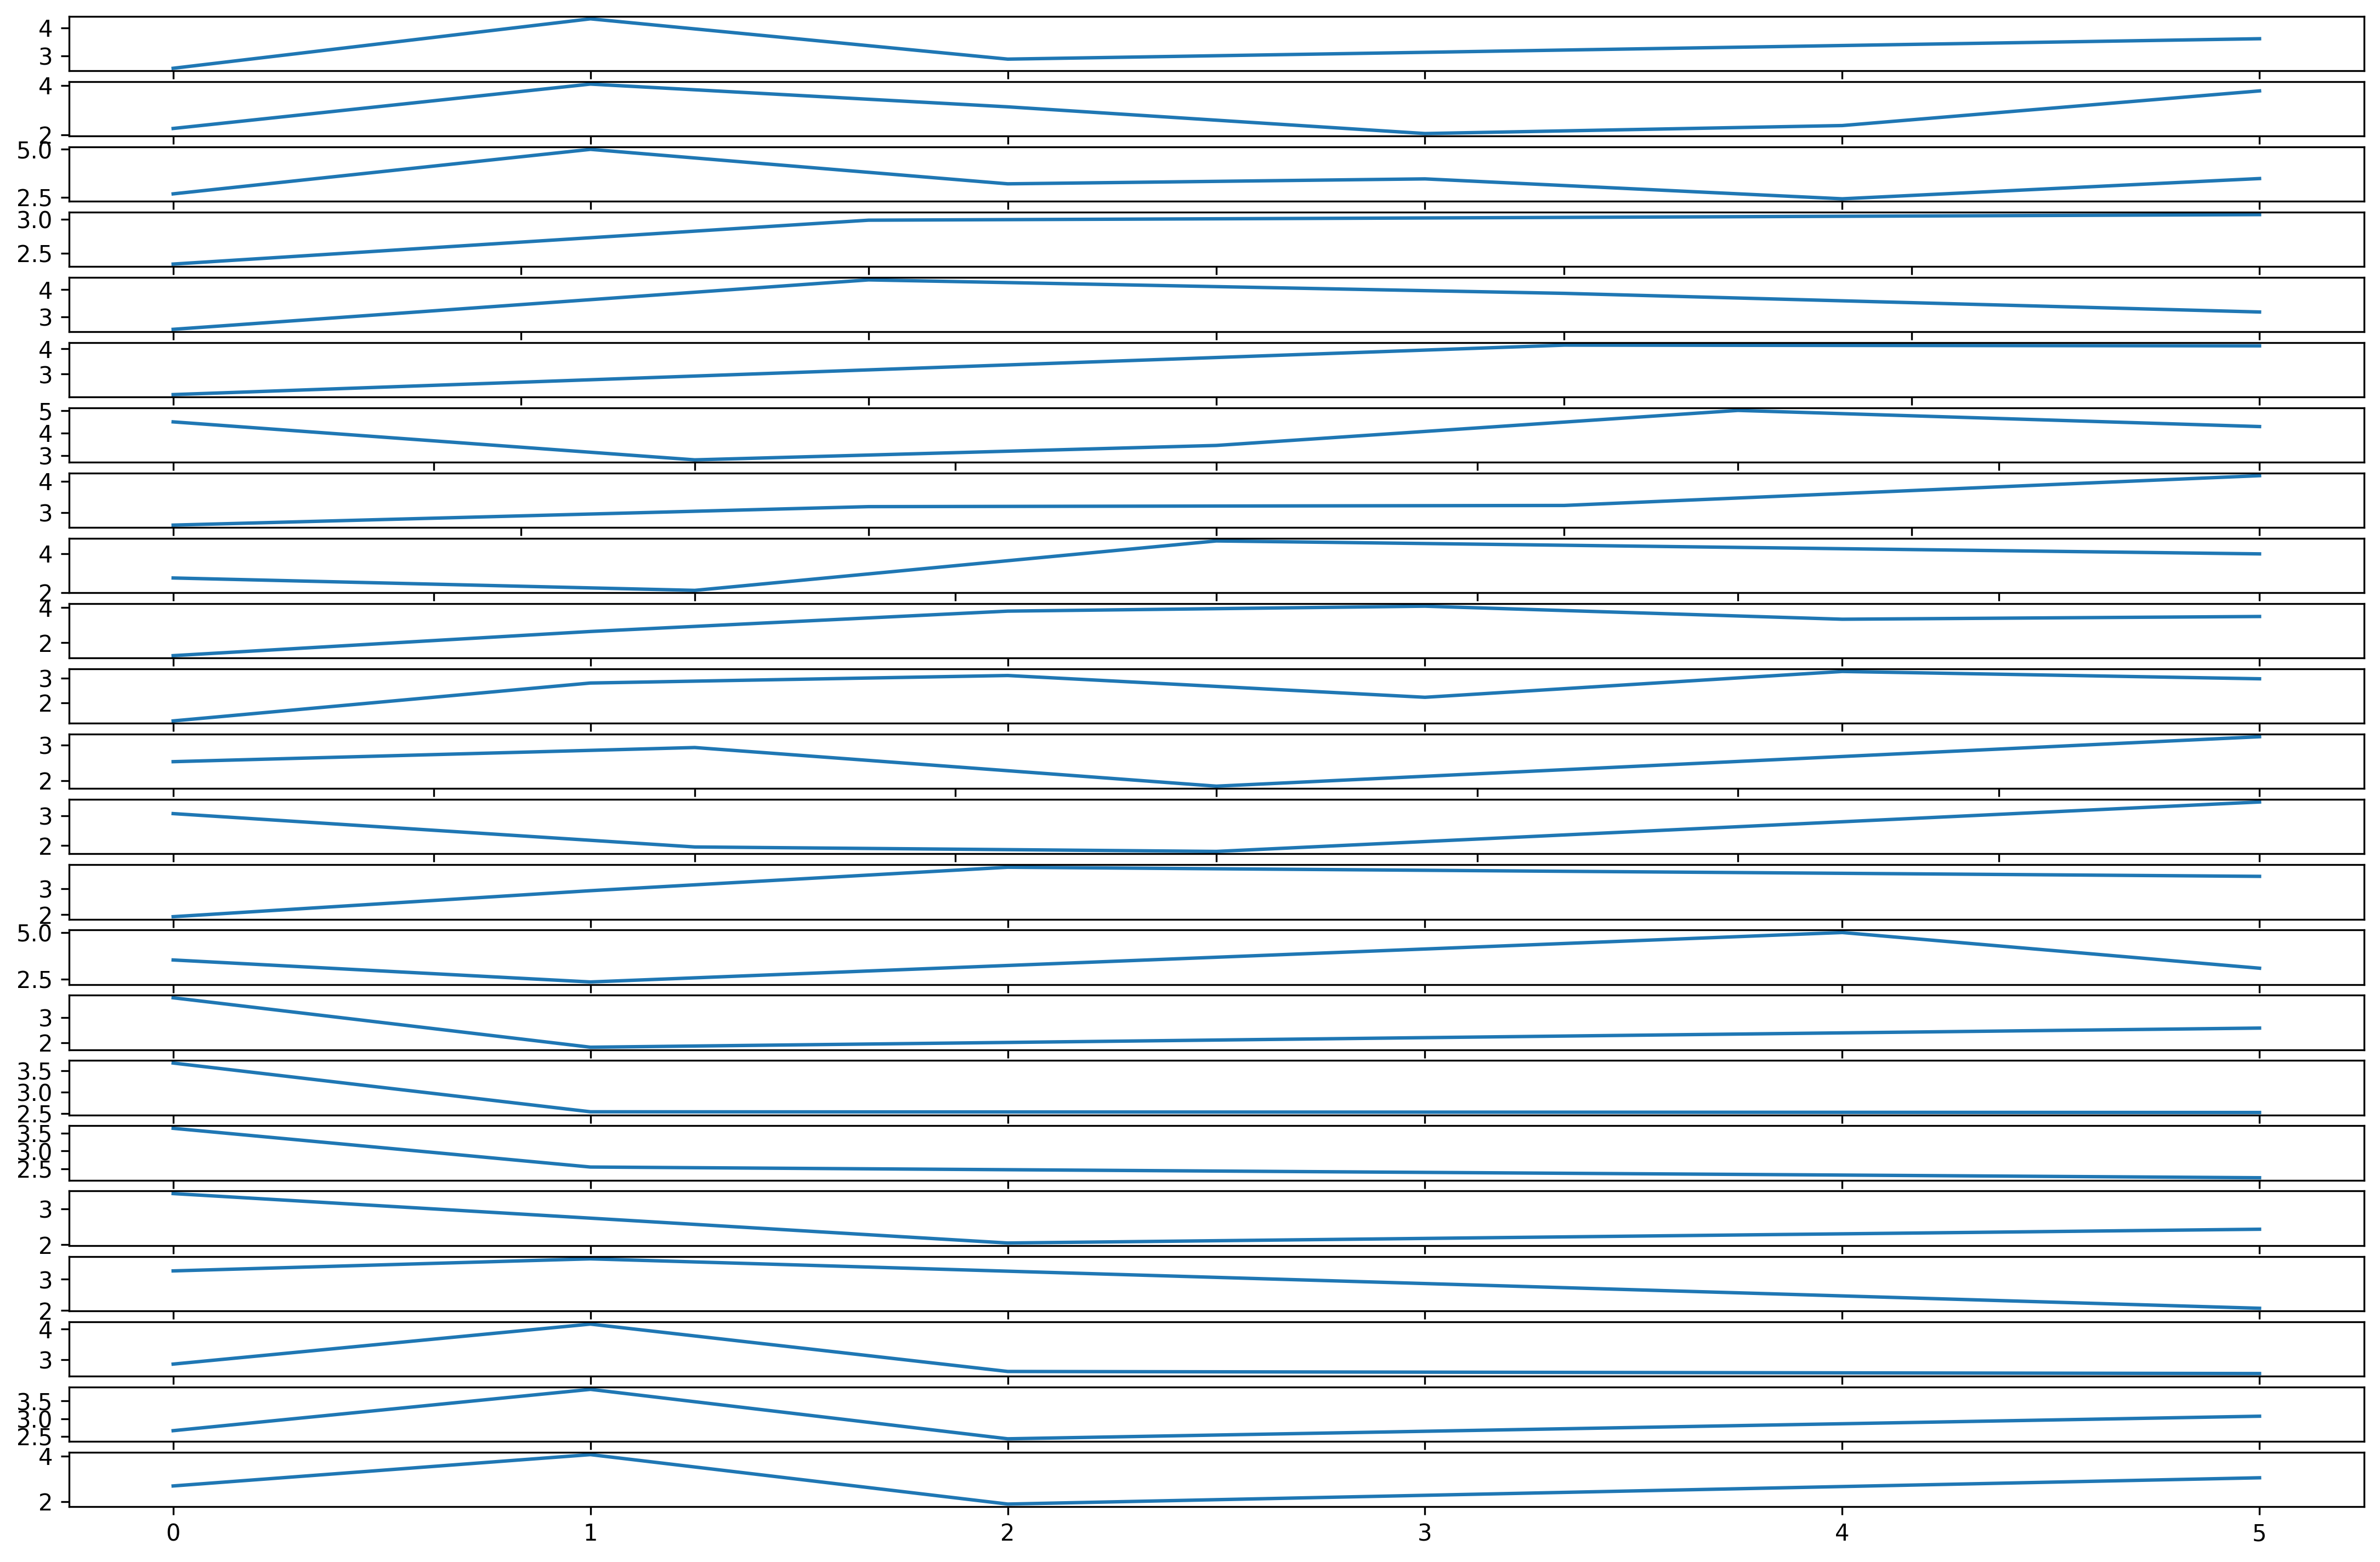

In [25]:
variables = review_ratings_processed.columns.drop(['user_id', 'malls'])

fig, ax = plt.subplots(len(variables), 1)
for idx, variable in enumerate(variables):
    mall_mean_ratings_by_var = \
        review_ratings_processed[[variable, 'malls']]\
                [review_ratings_processed[variable]\
                     .isin(np.arange(0.0, 9.0, 1.0))]\
                        .groupby(by=variable).mean()
    
    ax[idx].plot(mall_mean_ratings_by_var.index, mall_mean_ratings_by_var.values)
plt.show();

**Task:** Split the dataset into features that include all variables except **juice_bars** and user_id

In [26]:
X = review_ratings_processed.drop(['user_id', 'juice_bars'], axis=1)
y = review_ratings_processed['juice_bars']

**Task:** Set your seed to 42 and split the data into **80%** training and **20%** test sets 

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Task:** Set seed to 42 and fit a Random Forest with **10 trees/estimators** to the training set

In [28]:
rf_model = RandomForestRegressor(n_estimators=10, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

Question 10: What R-Squared value did the model achieve on the test set?

In [29]:
rf_model.score(X_test, y_test)

0.7336734749500864

**Task:** Predict **juice_bars** ratings for the full dataset (training and test combined) and append predictions to the table

In [30]:
data = pd.concat([
    X,
    review_ratings_processed['user_id'],
    y,
    pd.Series(rf_model.predict(X), name='juice_bars_rf_pred')
], axis=1)
data.head()

,churches,resorts,beaches,parks,theatres,museums,malls,zoo,restaurants,pubs_bars,...,gyms,bakeries,beauty_spas,cafes,view_points,monuments,gardens,user_id,juice_bars,juice_bars_rf_pred
0,1.90,1.93,1.95,5.00,2.02,2.00,2.01,2.00,2.01,2.11,...,1.40,1.41,1.44,0.58,0.99,1.89,1.89,User 777,1.83,1.830
1,1.37,1.59,1.42,1.81,1.80,1.79,1.81,2.65,2.63,2.63,...,0.50,0.51,0.63,1.43,1.51,1.36,1.35,User 5278,2.92,2.933
2,0.75,0.79,2.03,2.88,5.00,5.00,1.64,1.59,1.56,1.55,...,0.79,1.10,0.73,0.70,0.70,0.70,0.73,User 2374,5.00,5.000
3,1.22,5.00,1.28,5.00,5.00,2.83,2.58,1.72,5.00,4.94,...,0.58,0.59,0.71,1.27,5.00,1.26,1.21,User 943,0.93,0.928
4,1.12,1.15,5.00,3.27,5.00,5.00,5.00,1.99,1.79,2.58,...,0.00,0.00,0.00,0.50,1.09,1.08,1.09,User 4082,1.72,1.721


**Task:** Compute the squared residual for each user id, append to table and sort descending by squared residual 

In [31]:
data = pd.concat([
    data,
    pd.Series((data['juice_bars_rf_pred']-data['juice_bars'])**2, name='squared_residual')
], axis=1).sort_values('squared_residual', ascending=False)
data.head()

,churches,resorts,beaches,parks,theatres,museums,malls,zoo,restaurants,pubs_bars,...,bakeries,beauty_spas,cafes,view_points,monuments,gardens,user_id,juice_bars,juice_bars_rf_pred,squared_residual
3151,2.64,2.63,2.61,2.62,1.80,1.79,1.28,1.28,1.25,1.26,...,0.91,0.88,0.87,5.00,4.42,3.67,User 3636,5.00,0.827,17.413929
2937,2.02,2.39,2.38,2.40,5.00,3.85,4.21,2.77,2.35,2.78,...,0.91,0.92,0.93,0.94,5.00,1.60,User 1197,5.00,0.931,16.556761
203,1.36,1.39,1.41,2.54,3.17,3.18,5.00,5.00,5.00,5.00,...,0.53,0.57,0.84,1.47,1.37,1.36,User 1516,5.00,0.935,16.524225
676,2.08,2.28,1.68,1.27,1.24,1.23,1.24,1.41,1.64,1.30,...,2.48,5.00,2.50,5.00,2.46,2.45,User 5356,1.01,5.000,15.920100
2314,1.39,1.42,1.44,2.54,3.18,3.18,5.00,5.00,5.00,5.00,...,0.55,0.57,1.39,1.37,1.36,1.37,User 1505,5.00,1.064,15.492096


Question 11: How many users had a squared-residual **over 5.0**?

In [32]:
len(data[data['squared_residual'] > 5.0])

49

**Task:** Extract the first tree/estimator from the Random Forest Model

In [33]:
first_tree = rf_model.estimators_[0]

**Task:** Plot the decision tree with **max depth of 3**

In [34]:
# Visualize data
dot_data = tree.export_graphviz(first_tree,
                                feature_names=X.columns,
                                out_file=None,
                                max_depth=3,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('first_tree.png')

True

<img src='./first_tree.png' />

Question 12: What is the predicted rating for the path shown on quanthub.com [`hotels_other_lodgings <= 1.755`], [`art_galleries <= 3.645`]?

Predicted Rating: $2.57$ (2 d.p.)

**Task:** Create a sparse matrix with Location (e.g. resorts, beauty_spas, swimming_pools, etc.) on the rows and UserID on the columns with ratings as the values (fill any missing ratings for users with 0)

In [35]:
# Convert the user ids to int
review_ratings_processed['user_id'] = \
    review_ratings_processed['user_id'].apply(lambda entry: int(entry.split(' ')[-1]))

In [36]:
review_ratings_sparse_mat = \
    review_ratings_processed.set_index('user_id').transpose()
review_ratings_sparse_mat.head()

user_id,777,5278,2374,943,4082,574,2343,1131,110,4910,...,1430,280,994,995,1063,2739,344,3066,4944,4857
churches,1.90,1.37,0.75,1.22,1.12,0.90,0.74,0.61,1.25,1.08,...,0.87,2.33,0.54,0.54,1.45,2.58,1.28,2.17,0.92,2.11
resorts,1.93,1.59,0.79,5.00,1.15,0.93,2.53,1.54,1.27,1.31,...,0.89,2.27,0.58,0.58,1.83,2.60,2.42,2.16,5.00,2.63
beaches,1.95,1.42,2.03,1.28,5.00,1.67,2.73,1.55,1.32,2.63,...,2.89,5.00,5.00,5.00,1.83,2.37,2.42,2.17,5.00,2.62
parks,5.00,1.81,2.88,5.00,3.27,2.22,5.00,1.81,1.33,2.63,...,5.00,1.88,1.28,1.28,1.85,1.23,2.63,5.00,4.13,2.64
theatres,2.02,1.80,5.00,5.00,5.00,3.07,5.00,2.02,4.09,2.75,...,5.00,2.32,1.25,1.25,3.18,1.44,2.64,3.07,4.14,3.26


In [37]:
# Check if any features have
# missing values
review_ratings_sparse_mat.isna().sum(axis=1)

churches                 0
resorts                  0
beaches                  0
parks                    0
theatres                 0
museums                  0
malls                    0
zoo                      0
restaurants              0
pubs_bars                0
local_services           0
burger_pizza_shops       0
hotels_other_lodgings    0
juice_bars               0
art_galleries            0
dance_clubs              0
swimming_pools           0
gyms                     0
bakeries                 0
beauty_spas              0
cafes                    0
view_points              0
monuments                0
gardens                  0
dtype: int64

All missing values were removed.

**Task:** Apply a brute-force K-Nearest Neighbors algorithm to the matrix with a cosine metric 

In [38]:
# Brute-force kNN for the features
K = 5
nearest_neighbors = {}
cos_similarity = lambda a, b: np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
for feat, feat_val in review_ratings_sparse_mat.iterrows():
    similar_neighbors = []
    for neighbor, neighbor_val in review_ratings_sparse_mat.drop(feat, axis=0).iterrows():
        similar_neighbors.append((neighbor, cos_similarity(feat_val, neighbor_val)))
    nearest_neighbors[feat] = sorted(similar_neighbors, 
                                     key=lambda entry: entry[1], 
                                     reverse=True)[:K] 

Question 13: Which categories are included in the top 5 nearest neighbors to **cafes**?

In [39]:
nearest_neighbors['cafes']

[('churches', 0.733911223681981),
 ('monuments', 0.7059099389499416),
 ('view_points', 0.70351930147899),
 ('gardens', 0.7030691351907236),
 ('resorts', 0.6502699735647091)]